### Imports

In [ ]:
%load_ext autoreload
%autoreload 2

#########################################################################################
#########################################################################################
####### BEGIN OPTIONAL SECTION
####### Comment/Uncomment the following section whether you are running it from 
####### a local setup and not from Google Drive
#########################################################################################
#########################################################################################

GLB_INSTALL_DEPENDENCIES = True
GLB_USE_DRIVE_ACCOUNT = True

# Here to define dependencies
if GLB_INSTALL_DEPENDENCIES:
    !pip install transformers
    !pip install captum

if GLB_USE_DRIVE_ACCOUNT:
  from google.colab import drive
  drive.mount('/content/drive')
  %cd /content/drive/MyDrive/"Colab Notebooks"
  username = "IsaacOlguin"
  repository =  "AutomatedTraumaDetectionInGCT"
  %cd {repository}
  %pwd

#########################################################################################
#########################################################################################
####### END OPTIONAL SECTION
#########################################################################################
#########################################################################################

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import stats
import pandas as pd
import os
from os.path import join
import numpy as np

import torch

from transformers import BertForSequenceClassification, BertTokenizerFast#,  BertTokenizer
from transformers import AutoModelForSequenceClassification #AutoTokenizer
from transformers import BertTokenizer, BertConfig

import src.classification_model_utilities as mlclassif_utilities
import src.general_utilities as gral_utilities

from captum.attr import visualization as viz
from captum.attr import IntegratedGradients, LayerConductance, LayerIntegratedGradients
from captum.attr import configure_interpretable_embedding_layer, remove_interpretable_embedding_layer

In [ ]:
#path_model = "models/20230204203845_model_binary_GroNLP-hateBERT_Epochs-2_full.pt"
path_model = "models/20230205003321_model_binary_bert-base-uncased_Epochs-2_full.pt"
path_model_dict = "models/20230204203845_model_binary_GroNLP-hateBERT_Epochs-2_dict.pt"
model_name = "bert-base-uncased" #"GroNLP/hateBERT"
model_id = "bert"
_num_classes = 2
_output_attentions = True
_output_hidden_states = True

## Read Dataset

In [ ]:
global_config_file = gral_utilities.read_config_file("config.yml")

PATH_DATASET = global_config_file["general_set_up"]["dataset_filename"]
PATH_DIR_INPUT = global_config_file["general_set_up"]["input_dir_name"]
PATH_DIR_DATASET = global_config_file["general_set_up"]["dataset_dir_name"]
INDEX_COLUMNS_DATASET = global_config_file["dataset"]["index_columns_dataset"] # 1
LIST_NAME_COLUMNS_DATASET = global_config_file["dataset"]["list_columns_names"]

df_dataset = mlclassif_utilities.import_dataset_from_excel(join(PATH_DIR_INPUT, PATH_DIR_DATASET, PATH_DATASET), INDEX_COLUMNS_DATASET, LIST_NAME_COLUMNS_DATASET)
df_dataset.head()

In [ ]:
list_sentences = df_dataset[df_dataset["trauma"]==1]["text"]
list_sentences

## Load Model & tokenizer

In [ ]:
tokenizer = mlclassif_utilities.get_tokenizer(model_id, model_name) 
device = mlclassif_utilities.get_gpu_device_if_exists()

model = torch.load(path_model)
model.to(device)
model.eval()
model.zero_grad()

# Shap

In [ ]:
import scipy as sp
!pip install shap 
import shap

In [ ]:
tokenizer = BertTokenizerFast.from_pretrained(model_name, do_lower_case=False)

def f(x):
    tv = torch.tensor([tokenizer.encode(v, padding='max_length', max_length=512, truncation=True) for v in x]).cuda()
    outputs = model(tv)[0].detach().cpu().numpy()
    #print(outputs)
    scores = (np.exp(outputs).T / np.exp(outputs).sum(-1)).T
    val = sp.special.logit(scores[:,1]) # use one vs rest logit units
    return val

In [ ]:
explainer = shap.Explainer(f, tokenizer)

In [ ]:
'''
text = [
    "A.   I admitted to having participated in the genocide.  I denounced those with whom I committed that crime.",
    "THE WITNESS: I have been given a document; however, I do not know how to read or write.",
    "A.    As far as those four people are concerned, they were elected by the national congress, national MRND party congress.  That congress -- 20 people made up the préfectural committee, and then you must add the communal MRND chairmen.  Now, there were 11 préfectures, that means 220 people, to which you must add the communal chairmen, that's 145 people, and they all made up the congress, national congress.  And in the course of the congress they elected the members of the national committee, the national MRND committee.",
    "THE WITNESS: I have been given a document; however, I do not know how to read or write.",
    "A.   They were taken away to be killed.",
    "The first group was killed at the commune office; whereas the second group was killed --",
    "A.   When the first group was killed at the communal office, one Rudatinya, as well as**********, who is called*********, and the second group was taken by one Hasengineza, who went to kill them at Rubare."
]
'''

In [ ]:
#shap_values = explainer(text, fixed_context=1, batch_size=2)
shap_values = explainer(list_sentences[0:50], fixed_context=1, batch_size=2)

In [ ]:
shap.plots.text(shap_values[:100], display=True)


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
#resultado_plots = shap.plots.text(shap_values[:100], display=False)

In [ ]:
#resultado_plots

In [ ]:
#file = open('ShapExamplesClass1_BBU.html','w')
#file.write(resultado_plots)
#file.close()

### Other visualizations

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


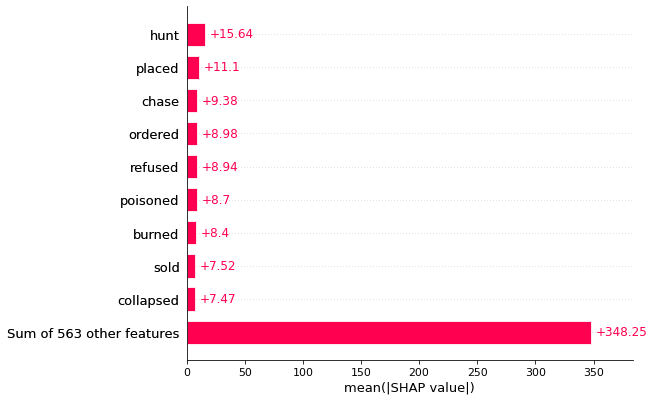

In [ ]:
shap.plots.bar(shap_values)

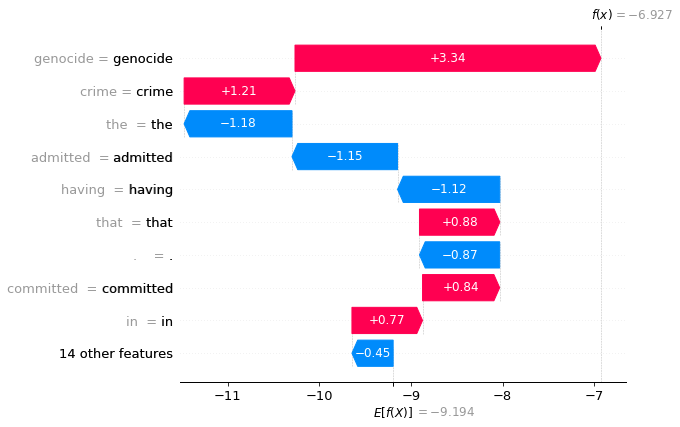

In [ ]:
shap.plots.waterfall(shap_values[0])

# Missclassifications

In [ ]:
ground_truth = df_dataset["trauma"]
list_sentences = df_dataset["text"]

all_spans_tokenized = mlclassif_utilities.get_all_spans_tokenized(
        tokenizer,
        list_sentences,
        _add_special_tokens = False, 
        _max_length = 512,
        _pad_to_max_length = True,
        _return_attention_mask = True, 
        type_tensors = "pt"
    )

input_ids = mlclassif_utilities.convert_list_into_pytorch_tensor(all_spans_tokenized[0])
attention_masks = mlclassif_utilities.convert_list_into_pytorch_tensor(all_spans_tokenized[1])
numeric_classes = mlclassif_utilities.convert_list_labels_into_pytorch_tensor(list(ground_truth))

input_ids = input_ids.to(device)
attention_masks = attention_masks.to(device)
numeric_classes = numeric_classes.to(device)

dataset = mlclassif_utilities.create_tensor_dataset(input_ids, attention_masks, numeric_classes)
dataloader = mlclassif_utilities.create_dataloader(dataset, 8)

def predict(model, device, dataloader):
    #return model(inputs)[0]
    predictions = list()
    model.eval()

    for batch in dataloader:
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        with torch.no_grad():
            result = model(b_input_ids, 
                          token_type_ids=None, 
                          attention_mask=b_input_mask,
                          labels=b_labels,
                          return_dict=True)
        loss = result.loss
        logits = result.logits

        predictions.extend(logits.argmax(dim=1).cpu().numpy())
    return predictions

predictions = predict(model, device, dataloader)

In [ ]:
list_indices = list()
for index, (true, prediction) in enumerate(zip(ground_truth, predictions)):
  if true != prediction:
    list_indices.append(index)

print(list_indices)

In [ ]:
json_info = {"ground_truth": ground_truth[list_indices], "predictions": np.asarray(predictions)[list_indices], "text": list_sentences[list_indices]}
df_info = pd.DataFrame.from_dict(json_info).reset_index()
df_info.to_excel("MisclassificationsBBU-wholeDS.xlsx")